In [18]:
import numpy as np 
import pandas as pd
import time


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")

%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report #for nice result formatting
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 

df = pd.DataFrame(wine_quality.data.original)

#replacing red and white in the target variable 0 and 1
df['color'] = df['color'].map({'red':0, 'white':1})

print(df)

correlation_matrix = df.corr()

# Correlation with 'color' column
correlation_with_color = correlation_matrix['color']

print(correlation_with_color)

avg_quality = df.groupby("color").mean()
avg_quality

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free_sulfur_dioxide  

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
color,,,,,,,,,,,,
0,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
1,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909


In [3]:
difference = avg_quality.diff().iloc[1]

# take the absolute value of the differences
absolute_difference = difference.abs()

# sort the absolute differences in descending order
sorted_absolute_difference = absolute_difference.sort_values(ascending=False)

# normalize the absolute differences
scaler = MinMaxScaler()
scaled_absolute_difference = pd.DataFrame(scaler.fit_transform(absolute_difference.values.reshape(-1, 1)),
                                           index=absolute_difference.index, columns=['Scaled Difference'])

# sort the scaled absolute differences in descending order
sorted_scaled_absolute_difference = scaled_absolute_difference.sort_values(by='Scaled Difference', ascending=False)

print("Scaled difference between the features of red and white wine:")
sorted_scaled_absolute_difference

Scaled difference between the features of red and white wine:


,Scaled Difference
total_sulfur_dioxide,1.000000
free_sulfur_dioxide,0.211453
residual_sugar,0.041897
fixed_acidity,0.015912
volatile_acidity,0.002686
quality,0.002603
sulphates,0.001802
pH,0.001307
alcohol,0.000964
citric_acid,0.000658


From this, it appears total sulfur dioxide, free sulfur dioxide, and residual sugars vary the most between red and white wine.

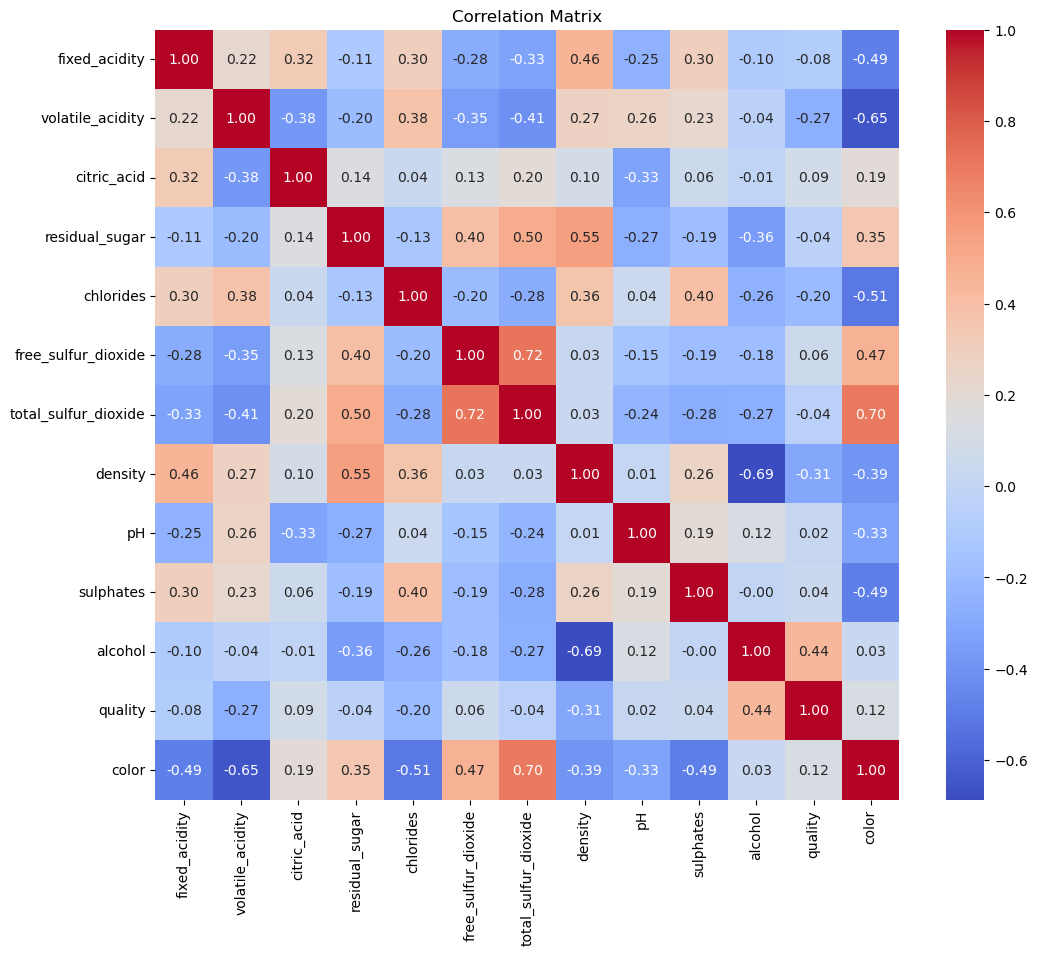

In [4]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [5]:
threshold = 0.7
highly_correlated = (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1.0)
correlated_variables = [pair for pair in highly_correlated if any(highly_correlated[pair])]
print(correlated_variables)

['free_sulfur_dioxide', 'total_sulfur_dioxide', 'color']


Correlated variables impact logistic regression outputs. We will drop these features from the data.

In [6]:
#Dropping variables listed above that are correlated
df = df.drop(['free_sulfur_dioxide', 'total_sulfur_dioxide'], axis=1)
#check to verify
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,0.99114,3.27,0.50,11.2,6,1
6493,6.6,0.32,0.36,8.0,0.047,0.99490,3.15,0.46,9.6,5,1
6494,6.5,0.24,0.19,1.2,0.041,0.99254,2.99,0.46,9.4,6,1
6495,5.5,0.29,0.30,1.1,0.022,0.98869,3.34,0.38,12.8,7,1


In [7]:
# define a function which takes the dataset as input and ouputs the processed dataset
def preprocessor(df):
    """
    Preprocesses the dataset by encoding categorical features using LabelEncoder

    Args:
        df (pandas.DataFrame): Input dataset

    Returns:
        pandas.DataFrame: Processed dataset with encoded categorical features
    """
    # make a copy of the original dataframe to avoid modifying the original data
    res_df = df.copy()
    
    # initialize LabelEncoder
    le = preprocessing.LabelEncoder()
    
    # encode categorical features using LabelEncoder
    res_df['sulphates'] = le.fit_transform(res_df['sulphates'])
    res_df['volatile_acidity'] = le.fit_transform(res_df['volatile_acidity'])
    res_df['residual_sugar'] = le.fit_transform(res_df['residual_sugar'])
    res_df['pH'] = le.fit_transform(res_df['pH'])
    res_df['chlorides'] = le.fit_transform(res_df['chlorides'])
    res_df['density'] = le.fit_transform(res_df['density'])
    res_df['alcohol'] = le.fit_transform(res_df['alcohol'])
    res_df['quality'] = le.fit_transform(res_df['quality'])
    res_df['citric_acid'] = le.fit_transform(res_df['citric_acid'])
    res_df['fixed_acidity'] = le.fit_transform(res_df['fixed_acidity'])
    
    # Return the processed dataframe
    return res_df

# Run the preprocessor function on the desired dataset
encoded_df = preprocessor(df)

In [8]:
#selecting features
X = encoded_df.drop(['color'],axis =1)
y = encoded_df['color']
y

0       0
1       0
2       0
3       0
4       0
       ..
6492    1
6493    1
6494    1
6495    1
6496    1
Name: color, Length: 6497, dtype: int64

Training Time of Logistic Regression: 2.074125051498413
Accuracy: 0.9861538461538462


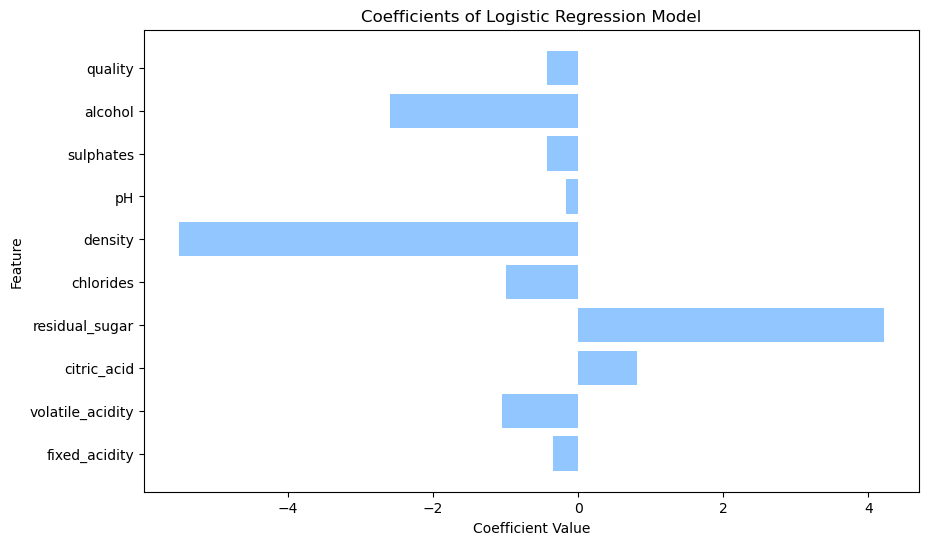

In [9]:
# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize features

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=23)

# Instantiate the logistic regression model
logreg = LogisticRegression()

# Training the model and measuring the time
start_time = time.time()
logreg.fit(X_train, y_train)
end_time = time.time()
logreg_train_time = end_time - start_time
print('Training Time of Logistic Regression:', logreg_train_time)

# Predicting using the trained model
y_pred_logreg = logreg.predict(X_test)

# Evaluating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy:", accuracy)

# Plotting the coefficients of the logistic regression model
plt.figure(figsize=(10, 6))
plt.barh(range(len(logreg.coef_[0])), logreg.coef_[0])
plt.yticks(range(len(X.columns)), X.columns)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients of Logistic Regression Model')
plt.show()

In the logistic regression model, coefficients represent the impact of each feature on predicting the positive class, which, in this case, corresponds to the classification of red wine. Features with larger positive coefficients exert a stronger positive influence on predicting the positive class. Therefore, for every unit increase in these features, such as residual sugar, there is a notable increase in the log-odds of the wine being classified as red. Conversely, features with larger negative coefficients exhibit a stronger negative influence on predicting the positive class. For instance, alcohol and density have larger negative coefficients, indicating that higher levels of these features are associated with a decreased likelihood of the wine being classified as red.

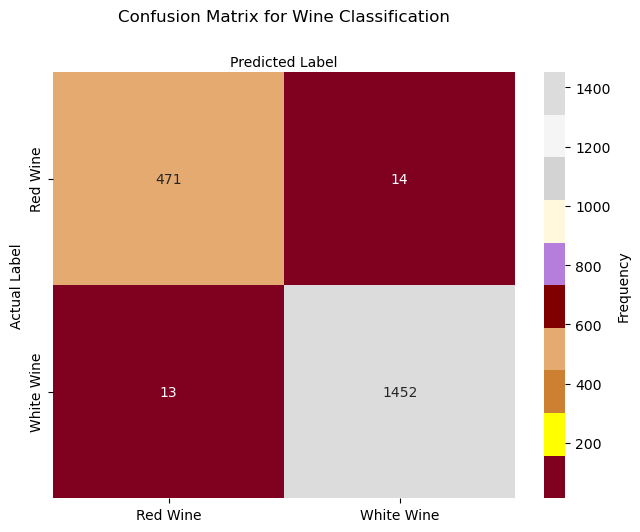

In [19]:
# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_logreg)

# Define class names for the plot
class_names=['Red Wine', 'White Wine']

# Create the figure and axes for the plot
fig, ax = plt.subplots()

# Define colors for the heatmap
colors = ["#800020", "#FFFF00", "#CD7F32", "#E5AA70", "#800000", "#B57EDC", "#FFF8DC", "#D3D3D3", "#F5F5F5", "#DCDCDC"]

# Create the heatmap with annotations and a colorbar
heatmap = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap=colors, fmt='g', cbar=True, cbar_kws={'label': 'Frequency'}, xticklabels=class_names, yticklabels=class_names)

# Set the position of the x-axis labels to the top
ax.xaxis.set_label_position("top")

# Adjust the layout for better appearance
plt.tight_layout()

# Set plot title and axis labels
plt.title('Confusion Matrix for Wine Classification', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()

In [20]:
# Generate classification report
classify_report = classification_report(y_test, y_pred_logreg, target_names=class_names)

# Output the classification report
print("Classification Report:\n", classify_report)

Classification Report:
               precision    recall  f1-score   support

    Red Wine       0.97      0.97      0.97       485
  White Wine       0.99      0.99      0.99      1465

    accuracy                           0.99      1950
   macro avg       0.98      0.98      0.98      1950
weighted avg       0.99      0.99      0.99      1950



Overall, the high precision, recall, and F1-score values, along with the high accuracy, indicate that the model performs very well in predicting both red and white wines.

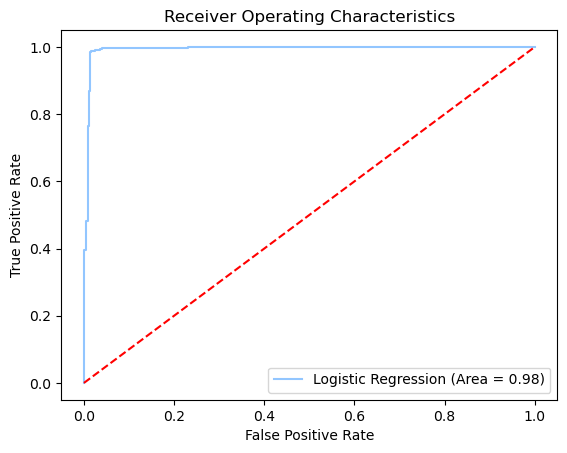

In [22]:
# Plot the Receiver Operating Characteristic (ROC) curve

# Calculate the ROC AUC score to quantify the model's performance
logreg_roc_auc = roc_auc_score(y_test, y_pred_logreg)

# Compute True Positive Rate (Sensitivity), False Positive Rate, and thresholds for different classification thresholds
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])

# Create a new figure for the ROC curve plot
plt.figure()

# Plot the ROC curve with True Positive Rate (Sensitivity) on the y-axis and False Positive Rate on the x-axis
plt.plot(fpr, tpr, label='Logistic Regression (Area = %0.2f)' % logreg_roc_auc)

# Plot a diagonal line representing a random classifier (no skill)
plt.plot([0, 1], [0, 1], 'r--')

# Label the x-axis and y-axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('Receiver Operating Characteristics')

# Add a legend to the plot, displaying the ROC AUC score
plt.legend()

# Display the plot
plt.show()

In [23]:
print(logreg_roc_auc)

0.9811301502410189


A high ROC AUC score (meaning it's close to 1) reflects a robust and accurate logistic regression model for predicting wine color.